## Telco Churn Prediction

#### Problem Statement:

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
For many incumbent operators, retaining high profitable customers is the number one business goal.
To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.


### Business Goal:

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September.
The months are encoded as 6, 7, 8 and 9, respectively. 

Business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.
To do this task well, understanding the typical customer behaviour during churn will be helpful.


### Understanding Customer Behaviour During Churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

* ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

* ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

* ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

### Focusing on reducing the High-value Churn
In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

In this project, Our scope is high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.


####  How to find out Filter high-value customers ? 

As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [4]:
!pip install -q klib

In [307]:
!pip install -q eli5

In [235]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

import klib

import plotly.graph_objs as go
import plotly
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as py
py.init_notebook_mode(connected=True)


from sklearn.preprocessing import MinMaxScaler
trans = MinMaxScaler()


from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report,accuracy_score, roc_curve, precision_score
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest


#  evaluating
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

plt.style.use('fivethirtyeight')
%matplotlib inline

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

# 1. Data Loading

In [7]:
PATH="data/"
df=pd.read_csv(PATH+'telecom_churn_data.csv')

In [8]:
print("Total columns in the dataset :- ",len(df.columns))

Total columns in the dataset :-  226


## 1.1 Data Preperation

####  Deriving Total Recharge Amount 

In [12]:
df.filter(like="total_rech_amt",axis=1).columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9'],
      dtype='object')

In [17]:
df['total_rech_amt'] = df['total_rech_amt_6']+df['total_rech_amt_7']+df['total_rech_amt_8']+df['total_rech_amt_9']
df_HVC = df[df['total_rech_amt'] >= df[['total_rech_amt']].quantile(0.7)[0]]
df_HVC.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.00,54.86,44.38,0.00,0.00,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,2.06,0.0,0.00,0.00,0.00,183.03,118.68,37.99,83.03,26.23,14.89,289.58,226.21,2.99,1.73,6.53,9.99,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,29.23,16.63,296.11,236.21,0.0,0.00,0.00,0.0,10.96,0.00,18.09,43.29,0.0,0.0,0.0,0.0,223.23,135.31,352.21,362.54,62.08,19.98,8.04,41.73,113.96,64.51,20.28,52.86,57.43,27.09,19.84,65.59,233.48,111.59,48.18,160.19,43.48,66.44,

#### Deriving Churn Flag

Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:
total_ic_mou_9

total_og_mou_9

vol_2g_mb_9

vol_3g_mb_9

In [19]:
df['Churn']=0
df.loc[((df['total_ic_mou_9'] == 0.0) | (df['total_og_mou_9'] == 0.0)) & (((df['vol_2g_mb_9'] == 0.0) | (df['vol_3g_mb_9']== 0.0))),'Churn']=1
df_HVC = df[df['total_rech_amt'] >= df[['total_rech_amt']].quantile(0.7)[0]]

<AxesSubplot:>

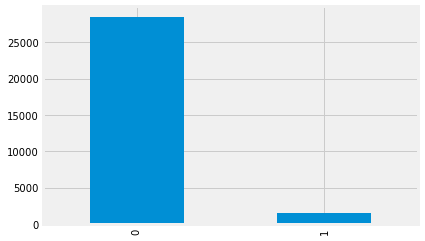

In [16]:
df_HVC.Churn.value_counts().plot(kind='bar')

<AxesSubplot:ylabel='Churn'>

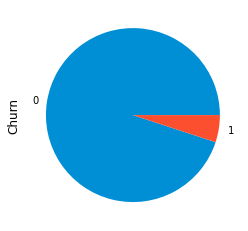

In [17]:
df_HVC.Churn.value_counts(normalize=True).plot(kind='pie')

In [18]:
df_HVC.Churn.value_counts(normalize=True)*100

0    94.959187
1     5.040813
Name: Churn, dtype: float64

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; Churn distribution is unbalanced <br><br>
&#9658; Need to follow appropirate sampling strategy for train & test split <br><br>
&#9658; Sensitivity will be appropirate measure for this unbalaced classification problem <br><br>

# 2. Data Quality Check

In [25]:
missing_smmry = pd.DataFrame(df.isnull().sum()/df.shape[0]*100,columns=['Missing_Percentage']).reset_index().rename(columns={'index':'field_name'})

In [26]:
missing_smmry[missing_smmry['Missing_Percentage']>5].sort_values('Missing_Percentage',ascending=False)

,field_name,Missing_Percentage
193,arpu_2g_6,74.846748
165,max_rech_data_6,74.846748
157,date_of_last_rech_data_6,74.846748
217,fb_user_6,74.846748
169,count_rech_2g_6,74.846748
...,...,...
75,spl_og_mou_8,5.378054
71,isd_og_mou_8,5.378054
115,std_ic_t2o_mou_8,5.378054
63,std_og_t2c_mou_8,5.378054


In [27]:
df_missing_smmry_gt_5pct = missing_smmry[missing_smmry['Missing_Percentage']>5].sort_values('Missing_Percentage',ascending=False)

In [28]:
missing_val_cols = df_missing_smmry_gt_5pct['field_name'].to_list()

GridSpec(6, 6)

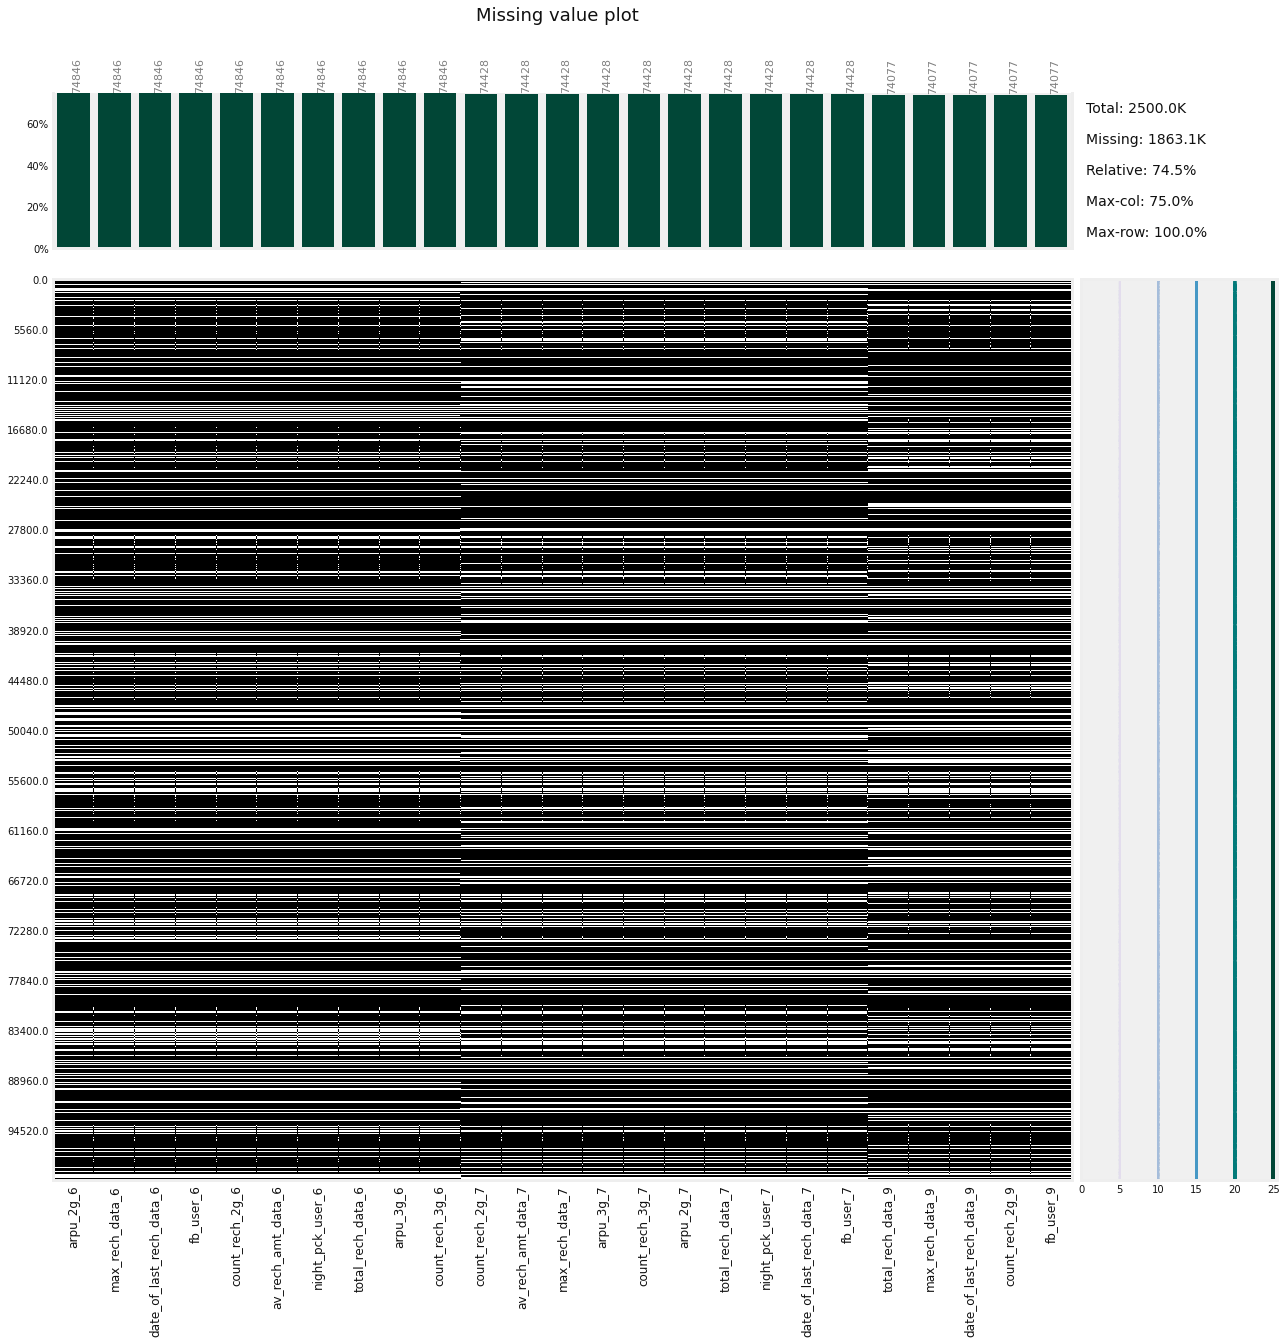

In [23]:
klib.missingval_plot(df[missing_val_cols].iloc[:,:25])

GridSpec(6, 6)

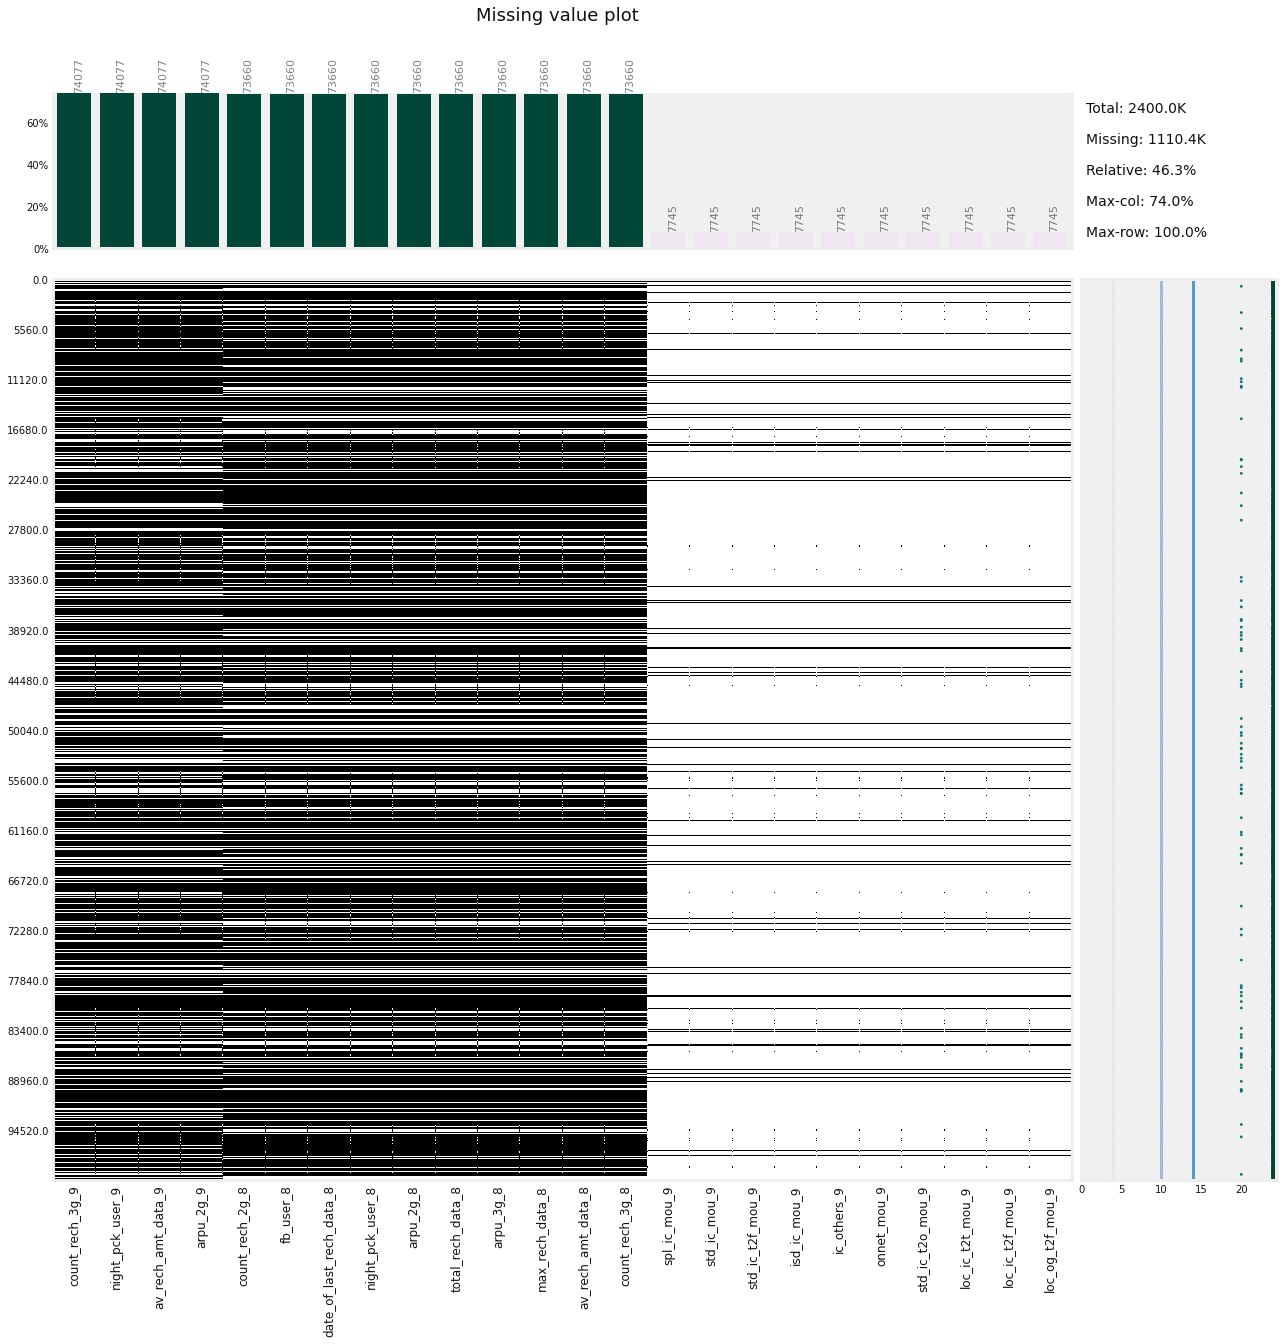

In [25]:
klib.missingval_plot(df[missing_val_cols].iloc[:,26:50])

GridSpec(6, 6)

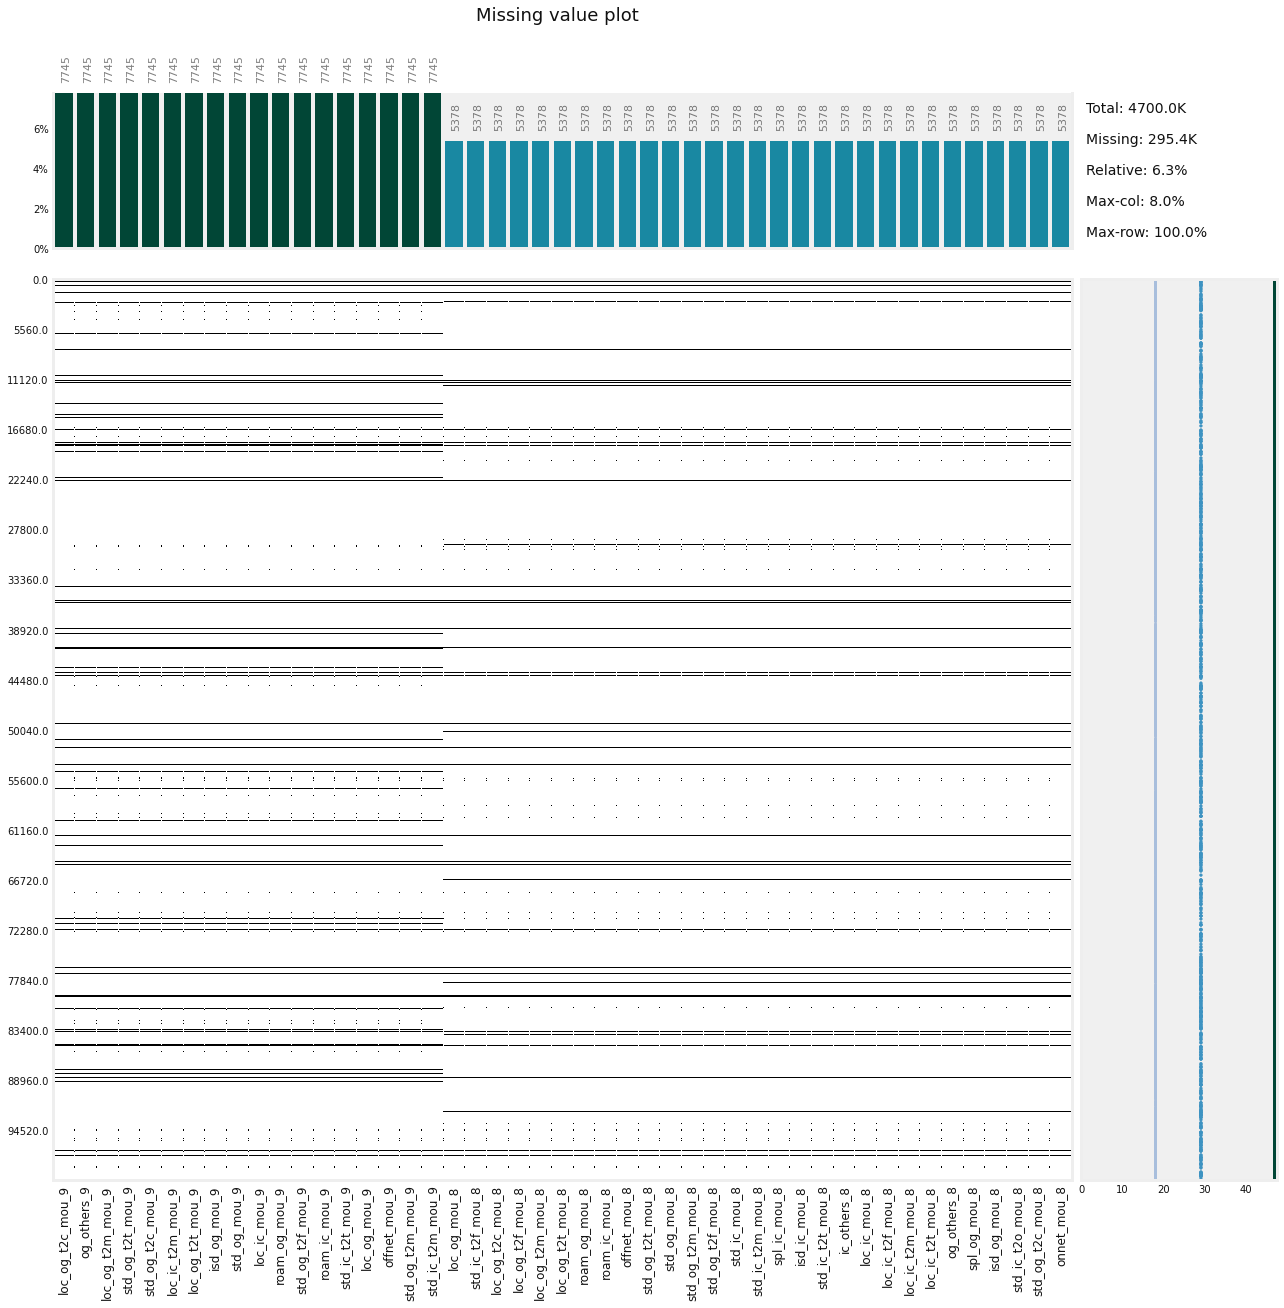

In [27]:
klib.missingval_plot(df[missing_val_cols].iloc[:,51:98])

In [29]:
df.select_dtypes('float').describe()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,

# 3. Data Analysis

## 3.1 Univariate Analysis

GridSpec(6, 5)

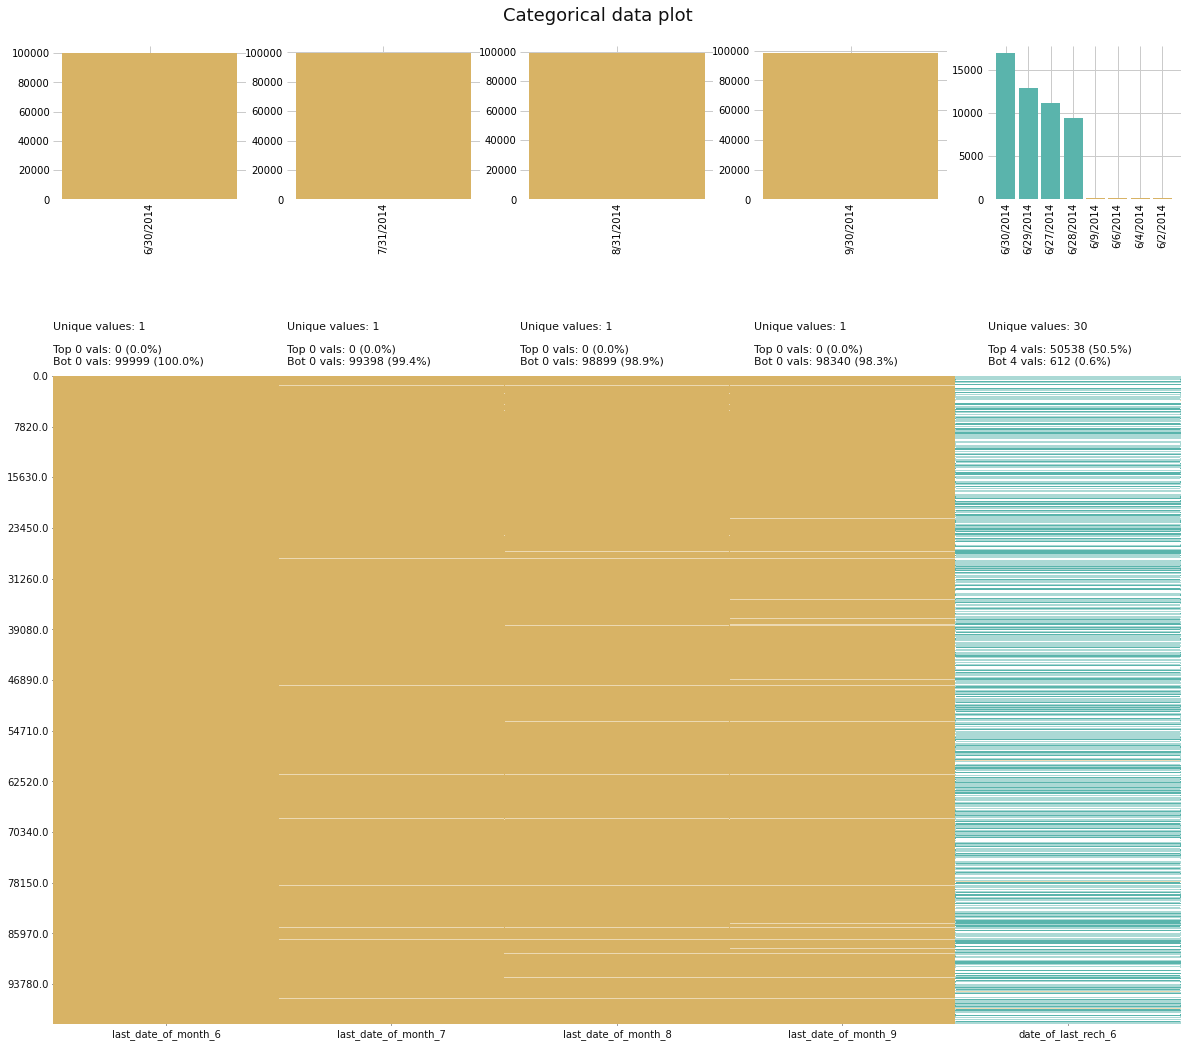

In [30]:
df_cat = df.select_dtypes('object')
klib.cat_plot(df_cat.iloc[:,:5], top=4, bottom=4)

GridSpec(6, 4)

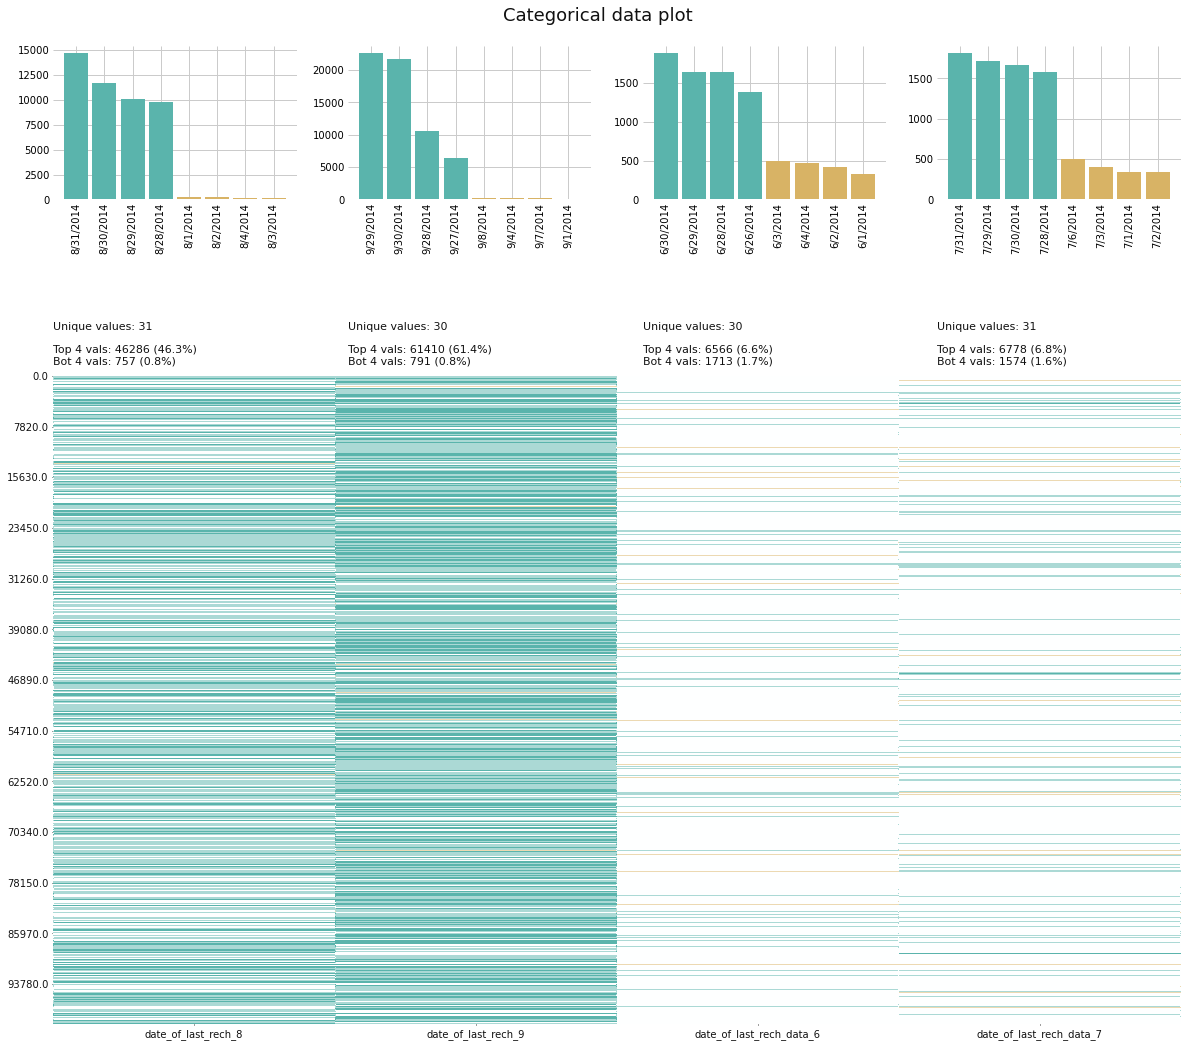

In [31]:
klib.cat_plot(df_cat.iloc[:,6:10], top=4, bottom=4)

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658;  <br><br>
&#9658; Need to follow appropirate sampling strategy for train & test split <br><br>
&#9658; Sensitivity will be appropirate measure for this unbalaced classification problem <br><br>

## 3.1 Bivariate Analysis 

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

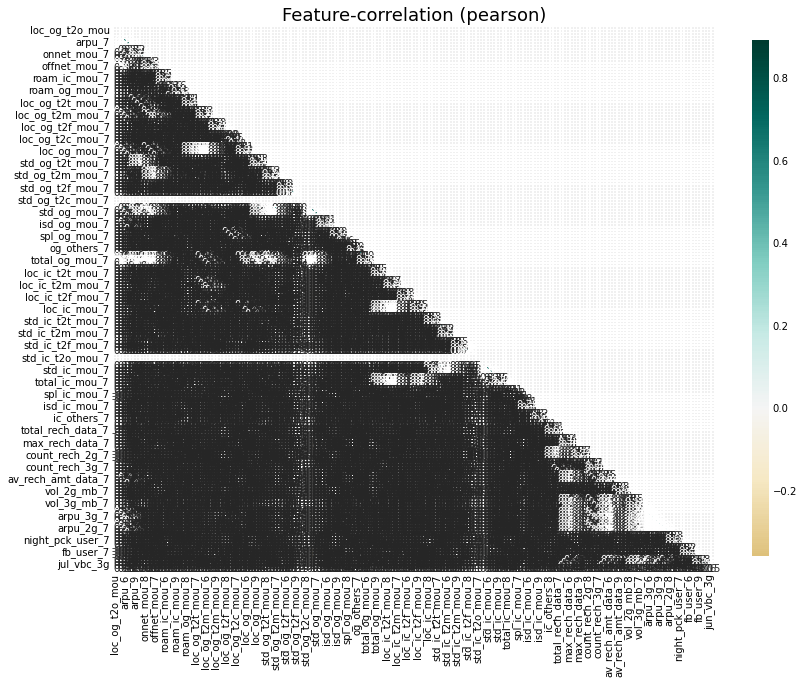

In [32]:
klib.corr_plot(df.select_dtypes('float'))

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; Features with missing values more than 20% is not considered for modeling <br><br>
&#9658; Mdedian & KNN imputation is used for missing values less than 20 percentage <br><br>

In [22]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt,Churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN

# 3. Feature Engineering

### 3.1 Removing the columns which is not required

In [29]:
final_cols = [ x for x in df_HVC.columns if x not in missing_smmry[missing_smmry['Missing_Percentage']>20].sort_values('Missing_Percentage',ascending=False)['field_name'].to_list()]
df_HVC_trim = df_HVC[final_cols]
final_cols_mth_ignore = [x for x in final_cols if x not in df_HVC_trim.filter(like="month_").columns.to_list()]
df_HVC_trim = df_HVC[final_cols_mth_ignore]
final_cols_9th_mth_ignore = [x for x in final_cols_mth_ignore if x not in df_HVC_trim.filter(like='_9',axis=1).columns.to_list()]
df_HVC_trim = df_HVC[final_cols_9th_mth_ignore]

##### Note -> **_9 columns are removed from the dataset & Constant dates bacause there is no variance with predictor variable

In [30]:
df_HVC_trim.select_dtypes("float").head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
3,0.0,0.0,0.0,221.338,251.102,508.054,99.91,54.39,310.98,123.31,109.01,71.68,0.00,54.86,44.38,0.00,28.09,39.04,73.68,34.81,10.61,107.43,83.21,22.46,1.91,0.65,4.91,0.0,0.00,0.00,183.03,118.68,37.99,26.23,14.89,289.58,2.99,1.73,6.53,0.00,0.00,0.00,0.0,0.0,0.0,29.23,16.63,296.11,0.0,0.00,0.00,10.96,0.00,18.09,0.0,0.0,0.0,223.23,135.31,352.21,62.08,19.98,8.04,113.96,64.51,20.28,57.43,27.09,19.84,233.48,111.59,48.18,43.48,66.44,0.00,1.33,38.56,4.94,1.18,0.00,0.00,0.0,0.0,0.0,45.99,105.01,4.94,280.08,216.61,53.13,0.59,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0
7,0.0,0.0,0.0,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.0,0.0,0.0,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.00,2.06,14.53,31.59,15.74,15.19,15.14,0.0,0.0,0.00,0.0,0.0,0.0,57.74,19.38,18.74,0.0
13,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.00,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,0.0,0.0,0.0,701.78,138.93,655.18,0.0,0.00,1.29,0.00,0.00,4.78,0.0,0.0,0.0,907.09,192.41,1015.26,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,215.58,26.11,255.26,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.0,0.0,0.0,423.81,68.09,474.41,968.61,172.58,1144.53,0.45,0.0,0.00,245.28,62.11,393.39,83.48,16.24,21.44,0.0,0.0,0.02,0.0,0.0,0.0,0.00,0.00,0.00,0.0
15,0.0,0.0,0.0,31.000,510.465,590.643,NaN,246.56,280.31,NaN,839.58,1011.91,NaN,0.00,0.00,NaN,0.88,0.00,NaN,16.13,44.79,NaN,38.99,92.53,NaN,5.13,4.83,NaN,9.78,0.00,NaN,60.26,142.16,NaN,230.43,235.51,NaN,775.66,914.54,NaN,0.00,0.00,NaN,0.0,0.0,NaN,1006.09,1150.06,NaN,0.00,0.00,NaN,18.89,0.00,NaN,0.0,0.0,0.00,1085.26,1292.23,NaN,16.91,16.19,NaN,36.94,45.76,NaN,7.24,9.51,NaN,61.11,71.48,NaN,1.76,2.68,NaN,40.06,14.31,NaN,0.00,0.00,NaN,0.0,0.0,NaN,41.83,16.99,0.00,105.86,89.71,NaN,0.0,0.61,NaN,0.00,0.00,NaN,2.91,0.61,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0

In [32]:
missing_smmry[missing_smmry['Missing_Percentage']>20].sort_values('Missing_Percentage',ascending=False)

,field_name,Missing_Percentage
157,date_of_last_rech_data_6,74.846748
165,max_rech_data_6,74.846748
217,fb_user_6,74.846748
197,night_pck_user_6,74.846748
193,arpu_2g_6,74.846748
189,arpu_3g_6,74.846748
173,count_rech_3g_6,74.846748
169,count_rech_2g_6,74.846748
177,av_rech_amt_data_6,74.846748
161,total_rech_data_6,74.846748


In [33]:
len(df_HVC_trim.columns)

141

### 3.2 Removing the unique ID Columns

In [35]:
df_HVC_trim.select_dtypes("object").columns
df_HVC_trim_num  = df_HVC_trim.select_dtypes("number")
df_HVC_trim_num = df_HVC_trim_num.reset_index()
id_cols = ['index','mobile_number','circle_id']
num_col_to_consider = [x for x in df_HVC_trim_num.columns if x not in id_cols]
df_HVC_trim_num = df_HVC_trim_num[num_col_to_consider]


In [36]:
len(df_HVC_trim_num.columns)

136

In [40]:
df_HVC_trim_catagory= df_HVC_trim.select_dtypes("object")

GridSpec(6, 6)

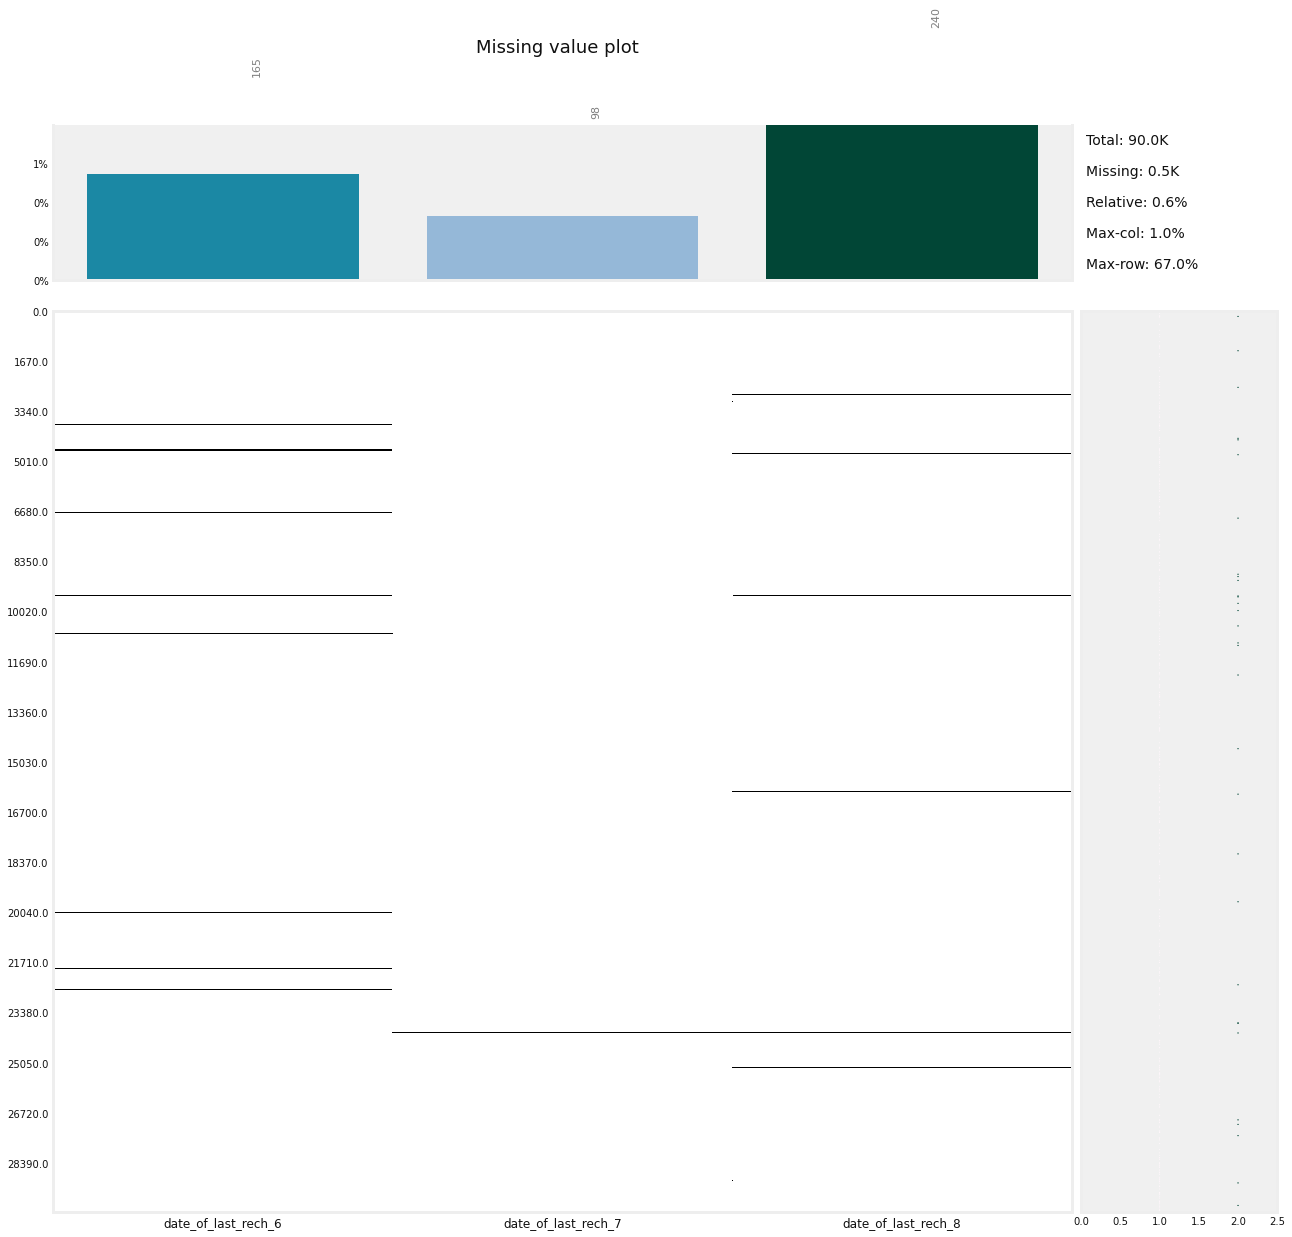

In [53]:
klib.missingval_plot(df_HVC_trim_catagory)

### 3.3 Handling Catagorical Variables

In [41]:
for x in df_HVC_trim_catagory.columns:
    df_HVC_trim_catagory[x].fillna(df_HVC_trim_catagory[x].mode(),inplace=True)
    df_HVC_trim_catagory[x] = pd.to_datetime(df_HVC_trim_catagory[x])
    df_HVC_trim_catagory[x]=df_HVC_trim_catagory[x].dt.day
df_HVC_trim_catagory.reset_index(inplace=True)
df_HVC_trim_catagory.drop(columns='index',axis=1,inplace=True)

for x in df_HVC_trim_catagory.columns:
    df_HVC_trim_catagory[x].fillna(df_HVC_trim_catagory[x].median(),inplace=True)

In [42]:
df_HVC_trim_final = pd.concat([df_HVC_trim_num,df_HVC_trim_catagory],axis=1)

In [44]:
len(df_HVC_trim_final.columns)

139

In [46]:
df_HVC_trim_final.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt,Churn,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,0.0,0.0,0.0,221.338,251.102,508.054,99.91,54.39,310.98,123.31,109.01,71.68,0.00,54.86,44.38,0.00,28.09,39.04,73.68,34.81,10.61,107.43,83.21,22.46,1.91,0.65,4.91,0.0,0.00,0.00,183.03,118.68,37.99,26.23,14.89,289.58,2.99,1.73,6.53,0.00,0.00,0.00,0.0,0.0,0.0,29.23,16.63,296.11,0.0,0.00,0.00,10.96,0.00,18.09,0.0,0.0,0.0,223.23,135.31,352.21,62.08,19.98,8.04,113.96,64.51,20.28,57.43,27.09,19.84,233.48,111.59,48.18,43.48,66.44,0.00,1.33,38.56,4.94,1.18,0.00,0.00,0.0,0.0,0.0,45.99,105.01,4.94,280.08,216.61,53.13,0.59,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10,11,18,230,310,601,60,50,50,30,50,50,0.0,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2491,0.00,0.00,0.00,0.0,1551,0,28.0,31.0,31.0
1,0.0,0.0,0.0,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.0,0.0,0.0,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.0,6008,1,27.0,25.0,26.0
2,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.00,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,0.0,0.0,0.0,701.78,138.93,655.18,0.0,0.00,1.29,0.00,0.00,4.78,0.0,0.0,0.0,907.09,192.41,1015.26,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,215.58,26.11,255.26,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.0,0.0,0.0,423.81,68.09,474.41,968.61,172.58,1144.53,0.45,0.0,0.00,245.28,62.

#### Not using date columns in scaling

In [48]:
from sklearn.preprocessing import MinMaxScaler
trans = MinMaxScaler()

In [49]:
df_HVC_trim_final_minmax = pd.DataFrame(trans.fit_transform(df_HVC_trim_num[df_HVC_trim_num.columns.to_list()]),columns=df_HVC_trim_num.columns.to_list())

In [50]:
df_HVC_trim_final_minmax.Churn.value_counts(normalize=True)*100

0.0    94.959187
1.0     5.040813
Name: Churn, dtype: float64

In [51]:
df_HVC_trim_final_minmax.isna().sum()/len(df_HVC_trim_final_minmax)*100

loc_og_t2o_mou    0.253207
std_og_t2o_mou    0.253207
loc_ic_t2o_mou    0.253207
arpu_6            0.000000
arpu_7            0.000000
                    ...   
jul_vbc_3g        0.000000
jun_vbc_3g        0.000000
sep_vbc_3g        0.000000
total_rech_amt    0.000000
Churn             0.000000
Length: 136, dtype: float64

In [52]:
df_HVC_trim_final_minmax.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt,Churn
0,0.0,0.0,0.0,0.082696,0.060957,0.042154,0.013544,0.006667,0.028921,0.014746,0.011276,0.005117,0.000000,0.014387,0.010643,0.000000,0.009989,0.007315,0.011456,0.004704,0.000987,0.022714,0.018259,0.004527,0.001303,0.000543,0.005288,0.0,0.000000,0.000000,0.017197,0.015464,0.003441,0.003561,0.001831,0.036132,0.000360,0.000186,0.000468,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.003466,0.001521,0.021181,0.0,0.000000,0.000000,0.010711,0.000000,0.013006,0.0,0.0,0.0,0.020913,0.011906,0.025081,0.009774,0.002143,0.001367,0.024279,0.014699,0.003534,0.030673,0.013661,0.011834,0.035942,0.011540,0.007768,0.007964,0.011453,0.000000,0.000287,0.011111,0.000875,0.000873,0.000000,0.000000,0.0,0.0,0.0,0.008424,0.015567,0.000829,0.039590,0.022333,0.008492,0.029858,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032573,0.079710,0.091837,0.006536,0.007686,0.013261,0.014963,0.012469,0.011238,0.007481,0.012469,0.011238,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.558078,0.00000,0.000000,0.000000,0.0,0.000709,0.0
1,0.0,0.0,0.0,0.110967,0.090525,0.119378,0.007841,0.006703,0.004863,0.054223,0.058669,0.023267,0.006211,0.008782,0.007588,0.006289,0.004477,0.007131,0.007991,0.004240,0.003746,0.065253,0.098171,0.032709,0.042380,0.046087,0.057330,0.0,0.000000,0.000000,0.039664,0.069567,0.023170,0.000584,0.002863,0.001499,0.006000,0.003421,0.003523,0.010596,0.036869,0.032269,0.0,0.0,0.0,0.007217,0.006870,0.005568,0.0,0.000033,0.001762,0.004398,0.000000,0.004673,0.0,0.0,0.0,0.045674,0.053605,0.024935,0.009154,0.003460,0.004642,0.046350,0.050468,0.021119,0.081267,0.051165,0.023578,0.065867,0.036736,0.030316,0.006757,0.002039,0.007052,0.019748,0.036593,0.025033,0.038627,0.030139,0.015922,0.0,0.0,0.0,0.033068,0.025658,0.032556,0.088551,0.057536,0.068528,0.010628,0.0,0.000000,0.000303,0.003060,0.009202,0.011710,0.010154,0.012514,0.016287,0.036232,0.035714,0.044899,0.019586,0.080274,0.394015,0.197007,0.355136,0.000000,0.000000,0.175096,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000

### 3.4 Correlation Study

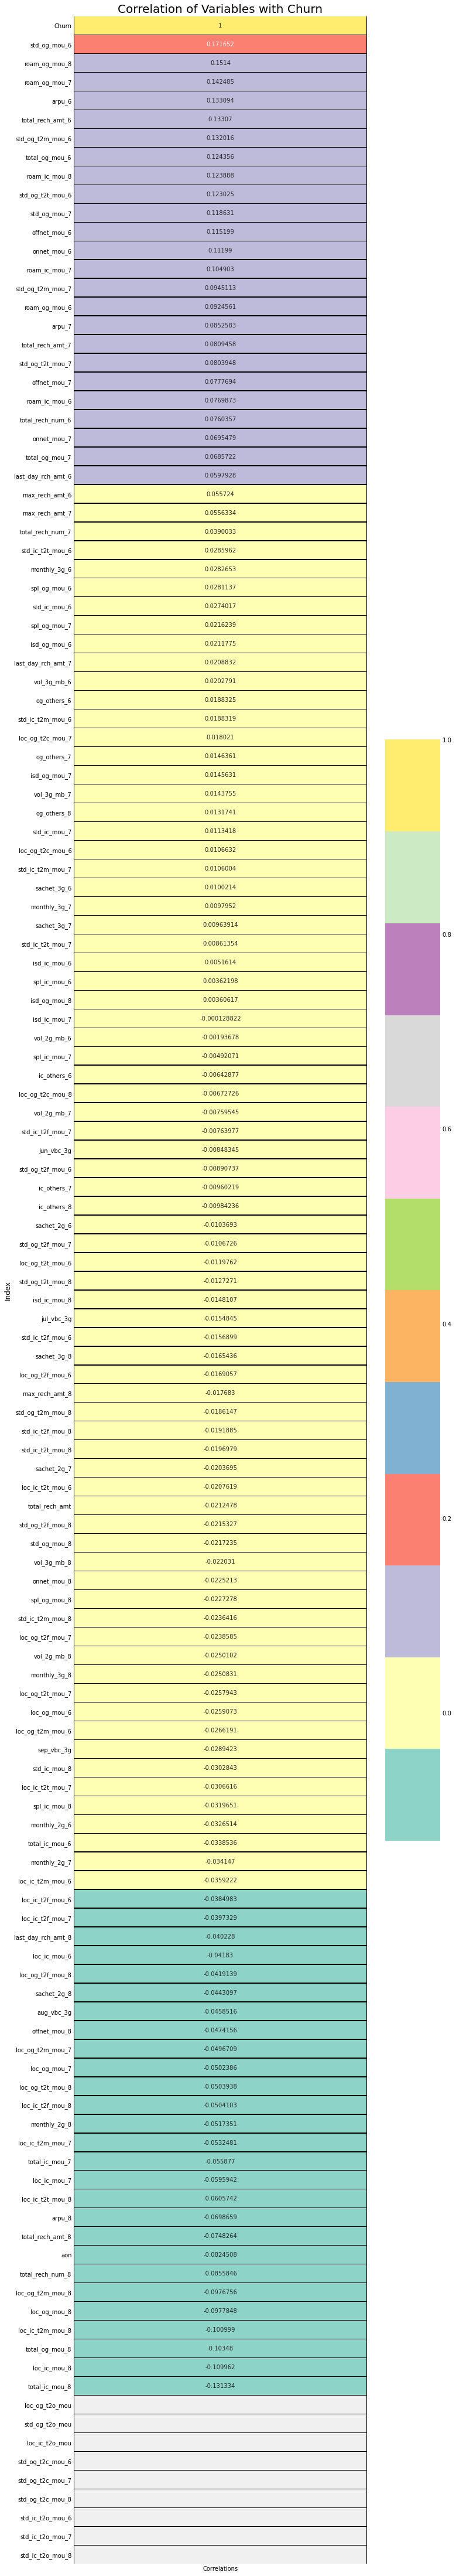

In [82]:
corr = df_HVC_trim_final_minmax.corrwith(df_HVC_trim_final_minmax['Churn']).reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False)

plt.figure(figsize=(10, 80))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='black')

plt.title("Correlation of Variables with Churn", fontsize=20)
plt.show()

### Features having Positive correlation with Target variable

In [83]:
list(corr[corr['Correlations']>0.05].reset_index().rename(columns={'Index':'columns'})['columns'])

['Churn',
 'std_og_mou_6',
 'roam_og_mou_8',
 'roam_og_mou_7',
 'arpu_6',
 'total_rech_amt_6',
 'std_og_t2m_mou_6',
 'total_og_mou_6',
 'roam_ic_mou_8',
 'std_og_t2t_mou_6',
 'std_og_mou_7',
 'offnet_mou_6',
 'onnet_mou_6',
 'roam_ic_mou_7',
 'std_og_t2m_mou_7',
 'roam_og_mou_6',
 'arpu_7',
 'total_rech_amt_7',
 'std_og_t2t_mou_7',
 'offnet_mou_7',
 'roam_ic_mou_6',
 'total_rech_num_6',
 'onnet_mou_7',
 'total_og_mou_7',
 'last_day_rch_amt_6',
 'max_rech_amt_6',
 'max_rech_amt_7']

### Features having Negative correlation with Target variable

In [84]:
list(corr[corr['Correlations']<-0.15].reset_index().rename(columns={'Index':'columns'})['columns'])

[]

### 3.5 Imputing missing values with KNN

In [54]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Creating  KNNImputer function

knn=KNNImputer(n_neighbors=3)

# Imputing the NaN values using KNN Imputer

df_knn = pd.DataFrame(knn.fit_transform(df_HVC_trim_final_minmax))
df_knn.columns=df_HVC_trim_final_minmax.columns

In [105]:
df_knn.isna().sum()/len(df_knn)*100

loc_og_t2o_mou        0.0
std_og_t2o_mou        0.0
loc_ic_t2o_mou        0.0
arpu_6                0.0
arpu_7                0.0
arpu_8                0.0
onnet_mou_6           0.0
onnet_mou_7           0.0
onnet_mou_8           0.0
offnet_mou_6          0.0
offnet_mou_7          0.0
offnet_mou_8          0.0
roam_ic_mou_6         0.0
roam_ic_mou_7         0.0
roam_ic_mou_8         0.0
roam_og_mou_6         0.0
roam_og_mou_7         0.0
roam_og_mou_8         0.0
loc_og_t2t_mou_6      0.0
loc_og_t2t_mou_7      0.0
loc_og_t2t_mou_8      0.0
loc_og_t2m_mou_6      0.0
loc_og_t2m_mou_7      0.0
loc_og_t2m_mou_8      0.0
loc_og_t2f_mou_6      0.0
loc_og_t2f_mou_7      0.0
loc_og_t2f_mou_8      0.0
loc_og_t2c_mou_6      0.0
loc_og_t2c_mou_7      0.0
loc_og_t2c_mou_8      0.0
loc_og_mou_6          0.0
loc_og_mou_7          0.0
loc_og_mou_8          0.0
std_og_t2t_mou_6      0.0
std_og_t2t_mou_7      0.0
std_og_t2t_mou_8      0.0
std_og_t2m_mou_6      0.0
std_og_t2m_mou_7      0.0
std_og_t2m_m

# 5. Modeling

## 5.1 Train & Test Split

In [176]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(df_knn, train_size = 0.7, test_size = 0.3, random_state = 100)

In [177]:
y_train = df_train.pop('Churn')
X_train = df_train

In [178]:
X_train.shape

(21010, 135)

In [179]:
y_test = df_test.pop('Churn')
X_test = df_test
X_test.shape

(9005, 135)

## 5.2 Importing RFE and LinearRegression

In [59]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [60]:
X_train.max()

loc_og_t2o_mou    0.0
std_og_t2o_mou    0.0
loc_ic_t2o_mou    0.0
arpu_6            1.0
arpu_7            1.0
                 ... 
aug_vbc_3g        1.0
jul_vbc_3g        1.0
jun_vbc_3g        1.0
sep_vbc_3g        1.0
total_rech_amt    1.0
Length: 135, dtype: float64

In [61]:
# Running RFE with the output number of the variable equal to 20
lm = LogisticRegression()
lm.fit(X_train, y_train)

LogisticRegression()

In [62]:
rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [63]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('loc_og_t2o_mou', False, 116),
 ('std_og_t2o_mou', False, 115),
 ('loc_ic_t2o_mou', False, 114),
 ('arpu_6', False, 13),
 ('arpu_7', False, 37),
 ('arpu_8', False, 15),
 ('onnet_mou_6', True, 1),
 ('onnet_mou_7', False, 18),
 ('onnet_mou_8', False, 3),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', False, 8),
 ('offnet_mou_8', False, 2),
 ('roam_ic_mou_6', False, 5),
 ('roam_ic_mou_7', True, 1),
 ('roam_ic_mou_8', False, 14),
 ('roam_og_mou_6', False, 32),
 ('roam_og_mou_7', True, 1),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 75),
 ('loc_og_t2t_mou_7', False, 101),
 ('loc_og_t2t_mou_8', False, 28),
 ('loc_og_t2m_mou_6', False, 81),
 ('loc_og_t2m_mou_7', False, 107),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 92),
 ('loc_og_t2f_mou_7', False, 78),
 ('loc_og_t2f_mou_8', False, 49),
 ('loc_og_t2c_mou_6', False, 67),
 ('loc_og_t2c_mou_7', False, 66),
 ('loc_og_t2c_mou_8', False, 65),
 ('loc_og_mou_6', False, 61),
 ('loc_og_mou_7', False, 106),
 ('loc_og_m

In [64]:
col = X_train.columns[rfe.support_]
col

Index(['onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_7', 'roam_og_mou_7',
       'roam_og_mou_8', 'loc_og_t2m_mou_8', 'loc_og_mou_8', 'std_og_mou_7',
       'std_og_mou_8', 'total_og_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_8',
       'total_ic_mou_8', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'max_rech_amt_7', 'last_day_rch_amt_6',
       'aug_vbc_3g', 'total_rech_amt'],
      dtype='object')

In [65]:
X_train.columns[~rfe.support_]

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7',
       'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'jul_vbc_3g', 'jun_vbc_3g',
       'sep_vbc_3g'],
      dtype='object', length=115)

In [66]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [67]:
# Adding a constant variable 
import statsmodels.api as sm
X_train_rfe = sm.add_constant(X_train_rfe)

In [68]:
lm = sm.Logit(y_train,X_train_rfe).fit()   # Running the linear model

Optimization terminated successfully.
         Current function value: 0.133697
         Iterations 10


In [69]:
#Let's see the summary of our linear model
print(lm.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                21010
Model:                          Logit   Df Residuals:                    20989
Method:                           MLE   Df Model:                           20
Date:                Wed, 27 Oct 2021   Pseudo R-squ.:                  0.3239
Time:                        21:38:19   Log-Likelihood:                -2809.0
converged:                       True   LL-Null:                       -4154.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.1872      0.127    -32.998      0.000      -4.436      -3.938
onnet_mou_6           -0.9442      0.675     -1.399      0.162      -2.267       0.379
offnet_mou_6        

In [70]:
X_test = sm.add_constant(X_test)

X_test_rfe = X_test[X_train_rfe.columns]
X_test_rfe = sm.add_constant(X_test_rfe)

y_predict = lm.predict(X_test_rfe)

### Lets find the Threshold value to derive Customer Churn

In [71]:
p, r, thresholds = precision_recall_curve(y_test, y_predict)

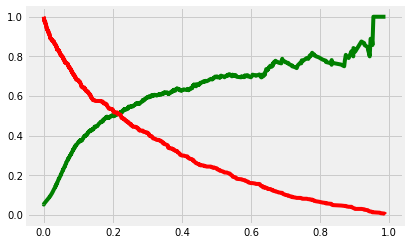

In [72]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [73]:
y_predict_cutt_off= y_predict.map(lambda x: 1 if x > 0.2 else 0)

In [74]:
df_test_pred = pd.DataFrame({'Churn':y_test,'Churn_Predicted':y_predict_cutt_off,'Predict_Probability':y_predict})

In [75]:
df_test_pred.head(20)

,Churn,Churn_Predicted,Predict_Probability
16986,0.0,0,0.053317
25150,0.0,0,0.026869
6311,0.0,0,0.015433
27403,0.0,0,0.030183
591,0.0,0,0.114843
14468,0.0,0,0.103188
12016,0.0,0,0.036910
11768,0.0,0,0.013246
26916,0.0,0,0.026340
18917,0.0,0,0.001376


In [122]:
# Creating a utility function to plot correlation matrix and roc_auc_curve

def show_metrics(model, y_test, y_pred,original_Xtest):
    fig = plt.figure(figsize=(20, 8))


    
    auc_roc = roc_auc_score(y_test, model.predict(original_Xtest))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict(original_Xtest))

    plt.plot(fpr, tpr, color='darkturquoise', lw=2, marker='o', label='Trained Model (area = {0:0.3f})'.format(auc_roc))
    plt.plot([0, 1], [0, 1], color='deeppink', lw=2, linestyle='--', label= 'No Skill (area = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver operating characteristic', fontsize=20)
    plt.legend(loc="lower right")
    plt.show()

### 5.2.1 Model Validation

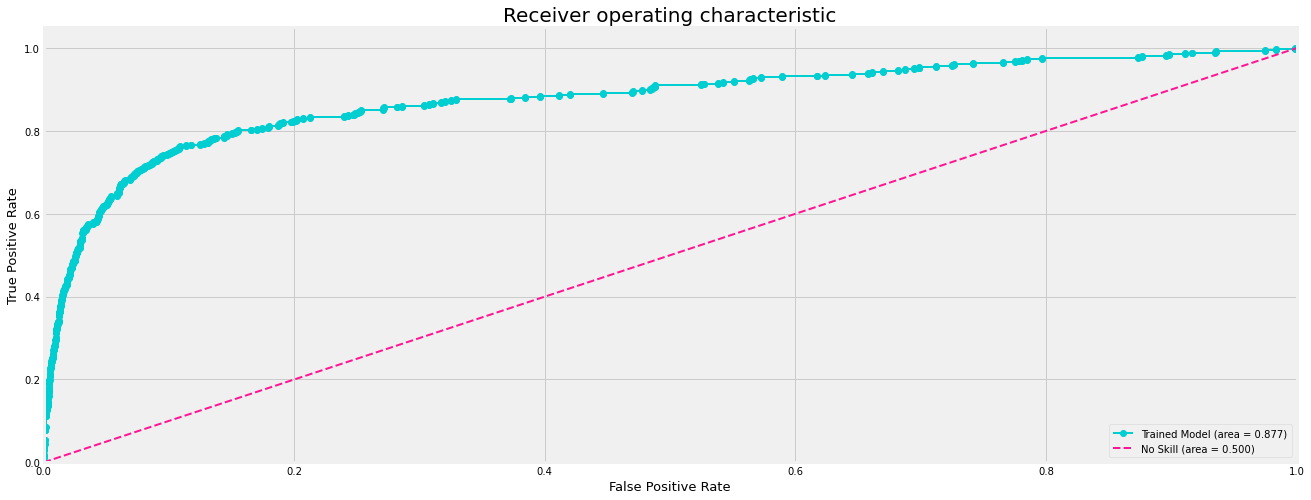

In [124]:
# plot ROC curve
show_metrics(lm, df_test_pred.Churn, df_test_pred.Churn_Predicted,X_test_rfe)

In [76]:
# Let's check the overall accuracy.
metrics.accuracy_score(df_test_pred.Churn, df_test_pred.Churn_Predicted)

0.9481399222654081

In [77]:
confusion2 = metrics.confusion_matrix(df_test_pred.Churn, df_test_pred.Churn_Predicted )
confusion2

array([[8290,  247],
       [ 220,  248]])

In [78]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [79]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.5299145299145299

In [80]:
# Let us calculate specificity
TN / float(TN+FP)

0.9710671195970482

&#9658; **Logistic regression did really well on the Churn class giving almost 94.8% accuracy and algo does well on the fraud class, Snesitivity of 53% and Specificity of 97%**

## Handling Data Imbalancing Issue

Here we'll use SMOTE technique to handle Imbalance Issue


In [81]:
!pip install -q imblearn

In [211]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=50)
X_train_sm,y_train_sm = sm.fit_resample(X_train,y_train)

In [212]:
print( X_train_sm.shape)
print( y_train_sm.shape)

(39930, 135)
(39930,)


## 5.3 Logistic Regression after SMOTE Technique implementation

In [213]:
lm1 = LogisticRegression()
lm1.fit(X_train_sm, y_train_sm)

LogisticRegression()

In [126]:
rfe1 = RFE(lm1, 20)             # running RFE
rfe1 = rfe1.fit(X_train_sm, y_train_sm)

In [86]:
list(zip(X_train_sm.columns,rfe.support_,rfe.ranking_))

[('loc_og_t2o_mou', False, 116),
 ('std_og_t2o_mou', False, 115),
 ('loc_ic_t2o_mou', False, 114),
 ('arpu_6', False, 13),
 ('arpu_7', False, 37),
 ('arpu_8', False, 15),
 ('onnet_mou_6', True, 1),
 ('onnet_mou_7', False, 18),
 ('onnet_mou_8', False, 3),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', False, 8),
 ('offnet_mou_8', False, 2),
 ('roam_ic_mou_6', False, 5),
 ('roam_ic_mou_7', True, 1),
 ('roam_ic_mou_8', False, 14),
 ('roam_og_mou_6', False, 32),
 ('roam_og_mou_7', True, 1),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 75),
 ('loc_og_t2t_mou_7', False, 101),
 ('loc_og_t2t_mou_8', False, 28),
 ('loc_og_t2m_mou_6', False, 81),
 ('loc_og_t2m_mou_7', False, 107),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 92),
 ('loc_og_t2f_mou_7', False, 78),
 ('loc_og_t2f_mou_8', False, 49),
 ('loc_og_t2c_mou_6', False, 67),
 ('loc_og_t2c_mou_7', False, 66),
 ('loc_og_t2c_mou_8', False, 65),
 ('loc_og_mou_6', False, 61),
 ('loc_og_mou_7', False, 106),
 ('loc_og_m

In [89]:
col1 = X_train_sm.columns[rfe.support_]
col1

Index(['onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_7', 'roam_og_mou_7',
       'roam_og_mou_8', 'loc_og_t2m_mou_8', 'loc_og_mou_8', 'std_og_mou_7',
       'std_og_mou_8', 'total_og_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_8',
       'total_ic_mou_8', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'max_rech_amt_7', 'last_day_rch_amt_6',
       'aug_vbc_3g', 'total_rech_amt'],
      dtype='object')

In [90]:
X_train_sm.columns[~rfe.support_]
X_train_rfe_sm = X_train_sm[col1]

In [91]:
import statsmodels.api as stm
X_train_rfe_stm = stm.add_constant(X_train_rfe_sm)

In [92]:
lm1 = stm.Logit(y_train_sm,X_train_rfe_stm).fit()   # Running the linear model

Optimization terminated successfully.
         Current function value: 0.392167
         Iterations 8


In [93]:
#Let's see the summary of our linear model
print(lm1.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                39930
Model:                          Logit   Df Residuals:                    39909
Method:                           MLE   Df Model:                           20
Date:                Wed, 27 Oct 2021   Pseudo R-squ.:                  0.4342
Time:                        21:40:55   Log-Likelihood:                -15659.
converged:                       True   LL-Null:                       -27677.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.4649      0.058    -42.212      0.000      -2.579      -2.350
onnet_mou_6           -3.5735      0.343    -10.406      0.000      -4.247      -2.900
offnet_mou_6        

In [94]:
X_test = stm.add_constant(X_test)

In [95]:
X_test_rfe = X_test[X_train_rfe.columns]
X_test_rfe = stm.add_constant(X_test_rfe)

In [96]:
y_predict = lm1.predict(X_test_rfe)

### Lets find the Threshold Again to derive Churn from Predicted Probabilities 

In [97]:
p, r, thresholds = precision_recall_curve(y_test, y_predict)

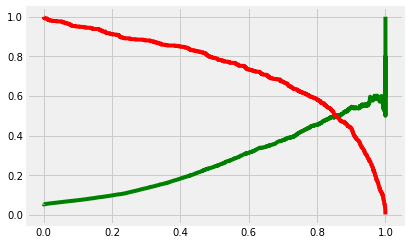

In [98]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [99]:
y_predict_cutt_off= y_predict.map(lambda x: 1 if x > 0.8 else 0)

In [100]:
df_test_pred = pd.DataFrame({'Churn':y_test,'Churn_Predicted':y_predict_cutt_off,'Predict_Probability':y_predict})

### 5.3.1 Model Evaluation

In [101]:
# Let's check the overall accuracy.
metrics.accuracy_score(df_test_pred.Churn, df_test_pred.Churn_Predicted)

0.9418101054969461

In [102]:
confusion2 = metrics.confusion_matrix(df_test_pred.Churn, df_test_pred.Churn_Predicted )
confusion2

array([[8209,  328],
       [ 196,  272]])

In [103]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [104]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.5811965811965812

In [105]:
# Let us calculate specificity
TN / float(TN+FP)

0.961579009019562

## 5.4 Introducing Logistic Regression with PCA:

In [214]:
X_train_sm.shape

(39930, 135)

In [215]:
X_test.shape

(9005, 135)

In [216]:
### Importing PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=42)

# PCA on training data
pca.fit(X_train_sm)

PCA(random_state=42)

In [ ]:
X_test.pop('const')

In [217]:
X_train_sm_pca=pca.fit_transform(X_train_sm)
print(X_train_sm_pca.shape)

X_test_pca=pca.transform(X_test)
print(X_test_pca.shape)

(39930, 135)
(9005, 135)


In [143]:
pca.components_

array([[ 4.53720492e-20, -1.38777878e-17,  0.00000000e+00, ...,
        -1.60771746e-02, -3.30447710e-03,  2.71902325e-03],
       [-5.36070373e-19,  1.66533454e-16, -1.11022302e-16, ...,
        -2.11233108e-02, -3.21399465e-03,  1.26901707e-02],
       [ 2.20702093e-19, -1.38777878e-16, -2.22044605e-16, ...,
         1.22118944e-02,  1.90680837e-03,  1.17402120e-02],
       ...,
       [-0.00000000e+00, -1.99253266e-01, -1.58932407e-01, ...,
        -1.56125113e-17, -1.19695920e-16,  1.48318857e-16],
       [-0.00000000e+00,  3.84548576e-02,  1.82338757e-02, ...,
         2.38524478e-18,  6.42931888e-17,  2.45788633e-16],
       [ 9.99999911e-01,  1.60873739e-04, -3.85947837e-04, ...,
         3.39660212e-18, -7.57035697e-19,  2.13638650e-17]])

### Executing Logistic Regression on PCA Data

In [218]:
logreg_pca = LogisticRegression()
logreg_pca.fit(X_train_sm_pca, y_train_sm)

# making the predictions
y_pred = logreg_pca.predict(X_test_pca)

y_pred_df = pd.DataFrame(y_pred)
print(y_pred_df.shape)

(9005, 1)


In [219]:

from sklearn.metrics import confusion_matrix, accuracy_score
print("Confusion Matirx \n ",confusion_matrix(y_test,y_pred),"\n")


# Accuracy of predicted Model
print("Accuracy with PCA: ",round(accuracy_score(y_test,y_pred),6))



Confusion Matirx 
  [[7169 1368]
 [  99  369]] 

Accuracy with PCA:  0.837091


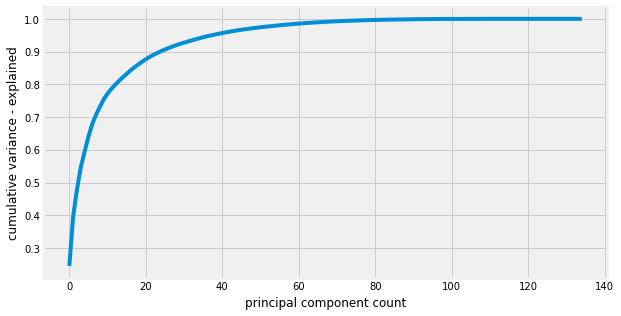

In [220]:
cumusum_var = np.cumsum(pca.explained_variance_ratio_)

# Creating scree plot
fig = plt.figure(figsize=[9,5])
plt.plot(cumusum_var)
plt.xlabel('principal component count')
plt.ylabel('cumulative variance - explained')
plt.show()

In [221]:
pca_25 = PCA(n_components=25)  ### As per graph , it shows 25 components have above 90% of the data variance

train_pca_25 = pca_25.fit_transform(X_train_sm)
print( train_pca_25.shape)

test_pca_25 = pca_25.transform(X_test)
print("Dimension for Test dataset using PCA: ", test_pca_25.shape)

(39930, 25)
Dimension for Test dataset using PCA:  (9005, 25)


In [222]:
logreg_pca_25 = LogisticRegression()
logreg_pca_25.fit(train_pca_25, y_train_sm)

# Implementing the predictions
y_pred_25 = logreg_pca_25.predict(test_pca_25)

y_pred_df_25 = pd.DataFrame(y_pred_25)
print("Shape of y_pred_df_25: ", y_pred_df_25.shape)

Shape of y_pred_df_25:  (9005, 1)


In [223]:
# Checking the Confusion matrix
print("Confusion Matirx for y_test & y_pred\n",confusion_matrix(y_test,y_pred_25),"\n")

# Checking the Accuracy of the Predicted model.
print("Accuracy of the logistic regression model with PCA: ",accuracy_score(y_test,y_pred_25))

Confusion Matirx for y_test & y_pred
 [[7101 1436]
 [ 109  359]] 

Accuracy of the logistic regression model with PCA:  0.8284286507495836


In [224]:
confusion3 = metrics.confusion_matrix(y_test, y_pred_25 )
confusion3

array([[7101, 1436],
       [ 109,  359]])

In [225]:
TP = confusion3[1,1] # true positive 
TN = confusion3[0,0] # true negatives
FP = confusion3[0,1] # false positives
FN = confusion3[1,0] # false negatives

In [226]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7670940170940171

In [227]:
# Let us calculate specificity
TN / float(TN+FP)

0.8317910272929601

## Data Prep with Stratifiled Cross Validation with SMOTE 

In [253]:
X = X_train_sm.reset_index()
X.drop(columns=['index'],inplace=True)
Y= pd.DataFrame({'Churn':y_train_sm})

In [265]:
# creating instance of statrifiedkfold split for 5 splits 
strat = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# splitting the data
for train_index, test_index in strat.split(X, Y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = Y.iloc[train_index], Y.iloc[test_index]

Train: [10508 10509 10510 ... 39927 39928 39929] Test: [    0     1     2 ... 29944 29945 29946]
Train: [    0     1     2 ... 29944 29945 29946] Test: [10508 10509 10510 ... 39927 39928 39929]


In [269]:
# Turning the splits into an array

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

## 5.3 SMOTE + HYPERPARAM TUNING

&#9658; **We will finally apply models and classify whether a certain transaction done a particular time is fraud or geniune. Thus, this is a binary classification problem.**

&#9658; **Important thing to note here is that we did SMOTE but we won't use that data, Why?**

**If we used that data to predict the classes then it will result in a problem know as 'Data Leakage' which is another term for using test data for prediction or cross validation. So, this sounds like a good point to use Pipelines. Pipelines make our life easier by specifying what order should the operations be done on the data.**

&#9658; **One thing we should keep in mind that we might get very high accuracy but we should focus on optimising out f1_score and recall as we want to perform better on fraud cases as they are the most important.**

In [275]:
# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# specifying the parameter grid for logistic regression
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Applying RandomsearchCV to find best model
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# iterating over all the splits
for train, test in strat.split(original_Xtrain, original_ytrain):
    
    # create pipeline with smote and the model 
    # sampling_strategy = minority because we want to only resample the minority class
    pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    
    # fit the pipeline
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    # finding mean for all the necessary measures to evaluate performance
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print(rand_log_reg.best_estimator_)
print("Accuracy: {0:0.2f}%".format(np.mean(accuracy_lst)*100))
print("Precision: {0:0.2f}".format(np.mean(precision_lst)))
print("Recall: {0:0.2f}".format(np.mean(recall_lst)))
print("f1 Score: {0:0.2f}".format(np.mean(f1_lst)))

LogisticRegression(C=10)
Accuracy: 84.69%
Precision: 0.85
Recall: 0.84
f1 Score: 0.85


### 5.3.1 Model Metrics :- 
* Hyperparameter - LogisticRegression(C=10)
* Accuracy: 84.69%
* Precision: 0.85
* Recall: 0.84
* f1 Score: 0.85

## 5.4 Random Forest Classifier

&#9658; **Now, let's try something which can take account of complex realationships. There are many such models but Random forest is bit better as it is a ensemble model and focuses on reducing variance i.e overfitting without much effecting the bias which is all we want. Also, this algorithm works in time complexity, O(d.n.log(n)) where d is the number of features.**

&#9658; **we have shown the best parameters after GridsearchCV and not the whole process itself as it is very time consuming and takes forever so you can try it yourself.**

In [277]:
# Random forest Classifier
rf_cfl = RandomForestClassifier(n_estimators = 200, 
                                 max_features = 3, 
                                 min_samples_leaf = 1, 
                                 min_samples_split = 2, 
                                 n_jobs = -1,
                                random_state = 42)

rf_cfl.fit(original_Xtrain, original_ytrain)
y_pred = rf_cfl.predict(original_Xtest)

### 5.4.1 Model metrics

In [285]:
confusion4 = metrics.confusion_matrix(original_ytest, y_pred )
confusion4

array([[9582,  400],
       [ 152, 9831]])

In [286]:
TP = confusion4[1,1] # true positive 
TN = confusion4[0,0] # true negatives
FP = confusion4[0,1] # false positives
FN = confusion4[1,0] # false negatives

In [287]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9847741159971952

In [288]:
# Let us calculate specificity
TN / float(TN+FP)

0.9599278701662993

In [289]:
print('Accuracy :{0:0.5f}'.format(accuracy_score(y_pred , original_ytest))) 
print('AUC : {0:0.5f}'.format(roc_auc_score(original_ytest , y_pred)))
print('Precision : {0:0.5f}'.format(precision_score(original_ytest , y_pred)))
print('Recall : {0:0.5f}'.format(recall_score(original_ytest , y_pred)))
print('F1 : {0:0.5f}'.format(f1_score(original_ytest , y_pred)))

Accuracy :0.97235
AUC : 0.97235
Precision : 0.96090
Recall : 0.98477
F1 : 0.97269


## 5.5 Tree Models with HyperParameter Tuning

In [294]:
# Best model using ExtraTrees

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

## Specifying the parameter grid for extra trees
extra_trees_params = {"n_estimators": [30,50,70,100], 'max_depth': [30,50,70,100], 'min_samples_split':[1,2,3,4,5]}

## Applying RandomsearchCV to find best model
rand_extra_trees = RandomizedSearchCV(ExtraTreesClassifier(random_state=42), extra_trees_params, n_iter=4)



## Iterating over all the splits
for train, test in strat.split(original_Xtrain, original_ytrain):
    
## Creating pipeline
  pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), rand_extra_trees)
  model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
  best_est = rand_extra_trees.best_estimator_
  prediction = best_est.predict(original_Xtrain[test])
    
## Computing performance measures
  accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
  precision_lst.append(precision_score(original_ytrain[test], prediction))
  recall_lst.append(recall_score(original_ytrain[test], prediction))
  f1_lst.append(f1_score(original_ytrain[test], prediction))
  auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print("Accuracy: {0:0.2f}%".format(np.mean(accuracy_lst)*100))
print("Precision: {0:0.2f}".format(np.mean(precision_lst)))
print("Recall: {0:0.2f}".format(np.mean(recall_lst)))
print("f1 Score: {0:2f}".format(np.mean(f1_lst)))

ExtraTreesClassifier(max_depth=100, min_samples_split=3, n_estimators=70,
                     random_state=42)
Accuracy: 96.06%
Precision: 0.95
Recall: 0.97
f1 Score: 0.960947


&#9658; **Best Model : ExtraTreesClassifier(max_depth=100, min_samples_split=3, n_estimators=70,
                     random_state=42)**

&#9658; **Results:** 

- **Accuracy: 96.19%**<br>
- **Precision: 0.95**<br>
- **Recall: 0.97**<br>
- **f1 Score: 0.96**<br>

In [296]:
best_model = ExtraTreesClassifier(max_depth=50, n_estimators=70, min_samples_split=5, random_state=42)
fitted_model = best_model.fit(original_Xtrain, original_ytrain)
predictions = fitted_model.predict(original_Xtest)

### 5.5 Model Evaluation

In [297]:
confusion5 = metrics.confusion_matrix(original_ytest, predictions )
confusion5

array([[9623,  359],
       [ 120, 9863]])

In [298]:
TP = confusion4[1,1] # true positive 
TN = confusion4[0,0] # true negatives
FP = confusion4[0,1] # false positives
FN = confusion4[1,0] # false negatives

In [299]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9847741159971952

In [300]:
# Let us calculate specificity
TN / float(TN+FP)

0.9599278701662993

print('Accuracy :{0:0.5f}'.format(accuracy_score(predictions , original_ytest))) 
print('AUC : {0:0.5f}'.format(roc_auc_score(original_ytest , predictions)))
print('Precision : {0:0.5f}'.format(precision_score(original_ytest , predictions)))
print('Recall : {0:0.5f}'.format(recall_score(original_ytest , predictions)))
print('F1 : {0:0.5f}'.format(f1_score(original_ytest , predictions)))

&#9658; **Using Extra Tree classifier we got 97% accuracy with Sensitivity , Precision is best Among all models, extra trees is performing better for Churn classification data**

# 6. Feature Importance

Text(0.5, 0, 'Random Forest Feature Importance')

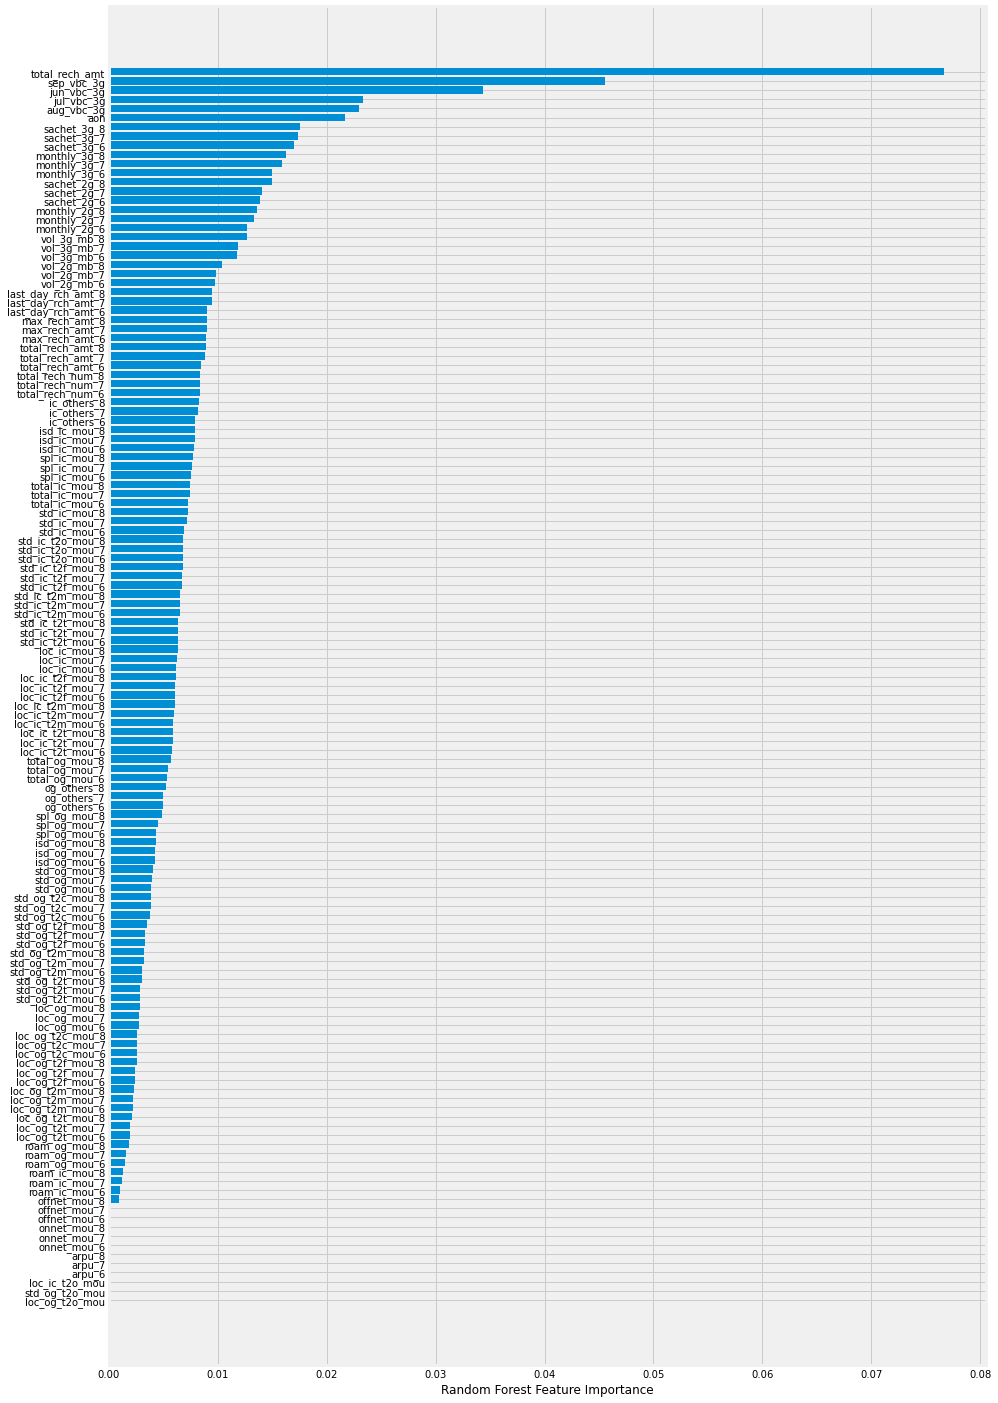

In [320]:
sorted_idx = rf_cfl.feature_importances_.argsort()
plt.figure(figsize=(14,25))
plt.barh(X.iloc[sorted_idx].columns.to_list(), rf_cfl.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## 6.1 Top 10 features Contributing to Churn

In [ ]:
df_feature_impt = pd.DataFrame({'Features':X.iloc[sorted_idx].columns.to_list(),'Importance_Score':rf_cfl.feature_importances_[sorted_idx]})

In [326]:
df_feature_impt.sort_values(by='Importance_Score',ascending=False).head(10)

,Features,Importance_Score
134,total_rech_amt,0.076691
133,sep_vbc_3g,0.045574
132,jun_vbc_3g,0.034334
131,jul_vbc_3g,0.023331
130,aug_vbc_3g,0.022968
129,aon,0.021671
128,sachet_3g_8,0.017578
127,sachet_3g_7,0.017404
126,sachet_3g_6,0.017029
125,monthly_3g_8,0.016295


# Conclusion


## Best model are mentioned below 


> ExtraTreesClassifier(max_depth=100, min_samples_split=3, n_estimators=70, random_state=42)
> Random Forest

## Features Contributes to Customer Churn :-  

* total_rech_amt
* Volume Based Cost(VBC) - 3G - Jun,July,Augest & September 
* AON - Age on network - number of days the customer is using the operator T network
* sachet_3g (Jun,July & Augest) Service schemes with validity smaller than a month 
* Monthly 3G - August 

## Recommendation to Business :- 

> Total Recharge Amount is important factor, Total Recharge Amount is less then probability of Churn is more 

> Volume Based Cost(VBC) - 3G - Jun,July,Augest & September is less then probability of Churn is more

> sachet_3g , If Customer uses smaller tenutre ( ex 10 days or 15 days ) ex- Tourist or Business travelers might belong to this catagory

> Monthly 3G - August which is the Action phase of churm 


